# **Модель MLP**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = pd.read_csv('result_features_no_fingerprint.csv')

In [3]:
target_col = 'score'


X = data.drop(columns=['score','SMILES'], axis=1)
y = data['score']

In [4]:
scaler = StandardScaler()


X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)


print("Средние значения после стандартизации (≈0):")
print(X_scaled.mean().round(3).head())

print("\nСтандартные отклонения после стандартизации (≈1):")
print(X_scaled.std().round(3).head())

Средние значения после стандартизации (≈0):
MW_EXACT   -0.0
XLogP       0.0
HBA        -0.0
HBD        -0.0
TPSA_NO     0.0
dtype: float64

Стандартные отклонения после стандартизации (≈1):
MW_EXACT    1.0
XLogP       1.0
HBA         1.0
HBD         1.0
TPSA_NO     1.0
dtype: float64


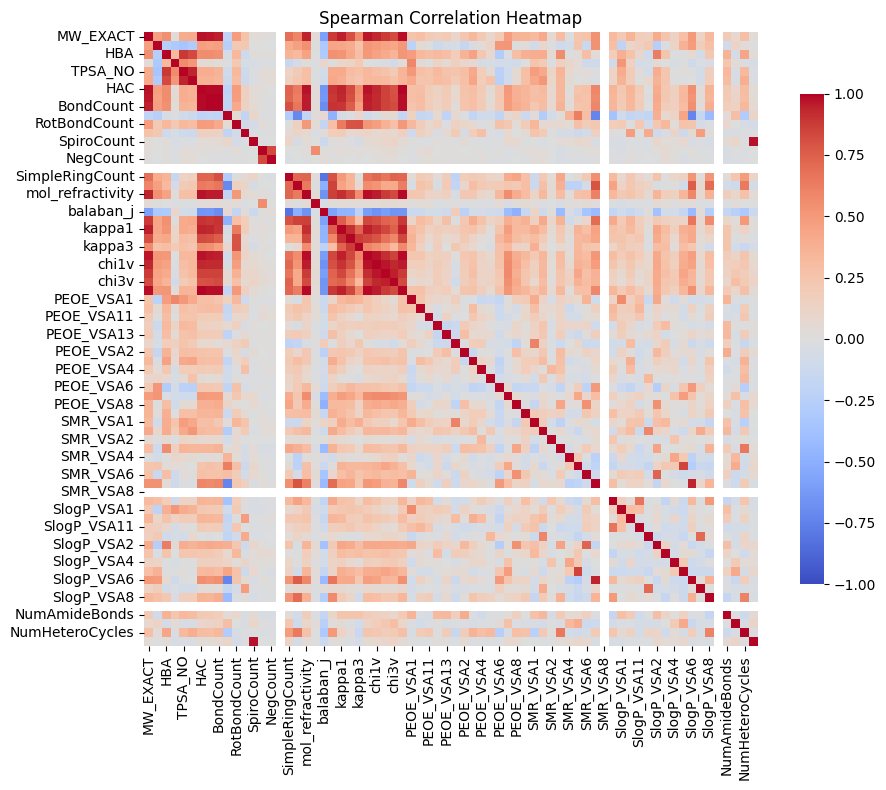

Оставшиеся признаки: ['MW_EXACT', 'XLogP', 'HBA', 'HBD', 'TPSA_NO', 'FSP3', 'RotBondCount', 'HalogenCount', 'SpiroCount', 'PosCount', 'NegCount', 'ComponentCount', 'SimpleRingCount', 'AromaticRingCount', 'formal_charge', 'balaban_j', 'kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'NumAmideBonds', 'NumAlifCarboxy', 'NumHeteroCycles']
Размер до: (89572, 70), после: (89572, 55)


In [5]:
X_spearman = X_scaled.copy()

corr_spearman = X_spearman.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman,
    annot=False,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

upper = corr_spearman.where(np.triu(np.ones(corr_spearman.shape), k=1).astype(bool))

# Список признаков с |corr| > 0.9
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]

X_filtered = X_spearman.drop(columns=to_drop)

print("Оставшиеся признаки:", X_filtered.columns.tolist())
print(f"Размер до: {X_spearman.shape}, после: {X_filtered.shape}")

y_filtered = y.loc[X_filtered.index]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

In [7]:
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.from_numpy(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [8]:
# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

**Создание модели**

In [9]:
class Net(nn.Module):
    def __init__(self, input_dim, activation='relu', dropout_rate=0.5, use_batch_norm=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512) if use_batch_norm else nn.Identity()
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256) if use_batch_norm else nn.Identity()        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128) if use_batch_norm else nn.Identity()        
        self.fc4 = nn.Linear(128, 1)      
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

        
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'selu':
            self.act = nn.SELU()
        else:
            self.act = nn.ReLU()


    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.act(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

**Перебор гиперпараметров**

In [10]:
param_grid = {
    
    'activation': ['relu', 'selu'],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'use_batch_norm': [True, False],
    'lr': [0.001, 0.01]  
}

Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 31.5165
Epoch [2/20], Loss: 19.0066
Epoch [3/20], Loss: 59.1709
Epoch [4/20], Loss: 28.9563
Epoch [5/20], Loss: 30.1391
Epoch [6/20], Loss: 21.1075
Epoch [7/20], Loss: 10.8484
Epoch [8/20], Loss: 17.5409
Epoch [9/20], Loss: 31.3349
Epoch [10/20], Loss: 28.8231
Epoch [11/20], Loss: 50.1203
Epoch [12/20], Loss: 21.8887
Epoch [13/20], Loss: 45.3518
Epoch [14/20], Loss: 21.0423
Epoch [15/20], Loss: 25.8239
Epoch [16/20], Loss: 94.1348
Epoch [17/20], Loss: 33.4726
Epoch [18/20], Loss: 19.6024
Epoch [19/20], Loss: 25.9113
Epoch [20/20], Loss: 28.2590
Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.001,


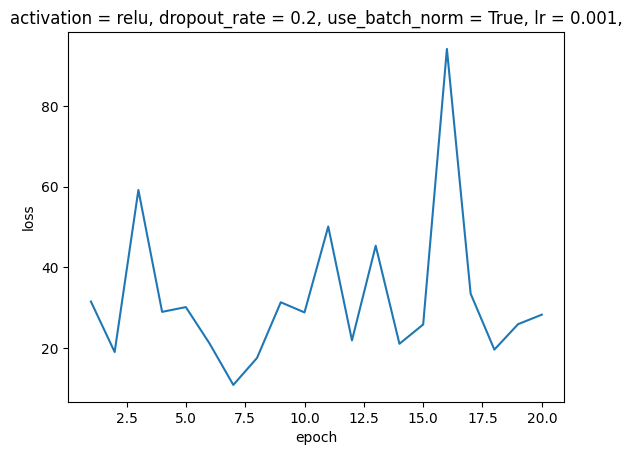

Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 173.0603
Epoch [2/20], Loss: 40.9919
Epoch [3/20], Loss: 36.6229
Epoch [4/20], Loss: 39.0983
Epoch [5/20], Loss: 12.4274
Epoch [6/20], Loss: 22.5607
Epoch [7/20], Loss: 12.0464
Epoch [8/20], Loss: 35.3095
Epoch [9/20], Loss: 12.9713
Epoch [10/20], Loss: 10.7902
Epoch [11/20], Loss: 24.8037
Epoch [12/20], Loss: 35.7424
Epoch [13/20], Loss: 6.5567
Epoch [14/20], Loss: 45.2741
Epoch [15/20], Loss: 166.9212
Epoch [16/20], Loss: 74.8176
Epoch [17/20], Loss: 64.4435
Epoch [18/20], Loss: 11.1553
Epoch [19/20], Loss: 33.1150
Epoch [20/20], Loss: 49.2320
Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.01,


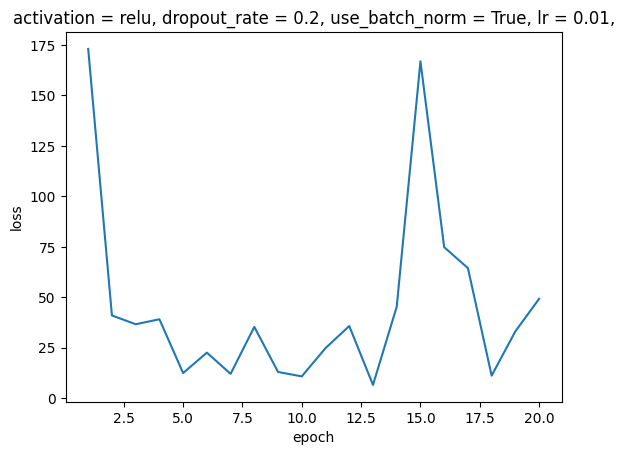

Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 31.1436
Epoch [2/20], Loss: 18.9110
Epoch [3/20], Loss: 38.7731
Epoch [4/20], Loss: 16.6742
Epoch [5/20], Loss: 42.6542
Epoch [6/20], Loss: 10.2010
Epoch [7/20], Loss: 37.0009
Epoch [8/20], Loss: 44.0173
Epoch [9/20], Loss: 59.7317
Epoch [10/20], Loss: 47.9365
Epoch [11/20], Loss: 21.8217
Epoch [12/20], Loss: 13.6068
Epoch [13/20], Loss: 29.3449
Epoch [14/20], Loss: 25.3242
Epoch [15/20], Loss: 22.7282
Epoch [16/20], Loss: 17.8087
Epoch [17/20], Loss: 24.4223
Epoch [18/20], Loss: 34.0608
Epoch [19/20], Loss: 12.9745
Epoch [20/20], Loss: 29.9879
Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.001,


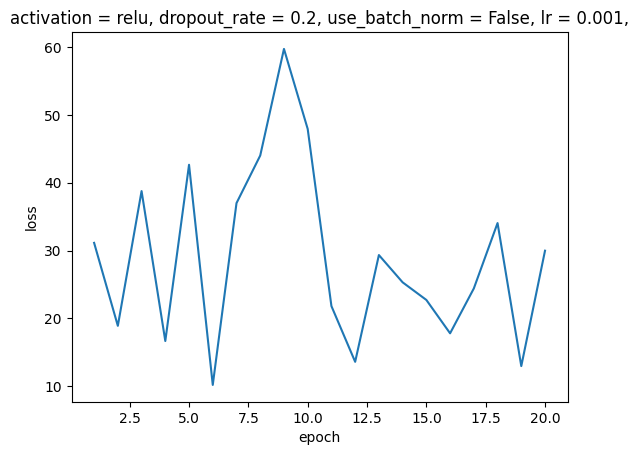

Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 102.3028
Epoch [2/20], Loss: 32.6718
Epoch [3/20], Loss: 6.4126
Epoch [4/20], Loss: 19.2232
Epoch [5/20], Loss: 20.8111
Epoch [6/20], Loss: 31.2895
Epoch [7/20], Loss: 27.9611
Epoch [8/20], Loss: 14.7621
Epoch [9/20], Loss: 31.0083
Epoch [10/20], Loss: 59.6055
Epoch [11/20], Loss: 13.6613
Epoch [12/20], Loss: 26.9018
Epoch [13/20], Loss: 14.9615
Epoch [14/20], Loss: 8.7966
Epoch [15/20], Loss: 31.3213
Epoch [16/20], Loss: 37.0059
Epoch [17/20], Loss: 12.2433
Epoch [18/20], Loss: 172.3488
Epoch [19/20], Loss: 15.4432
Epoch [20/20], Loss: 30.4875
Гиперпараметры модели: activation = relu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.01,


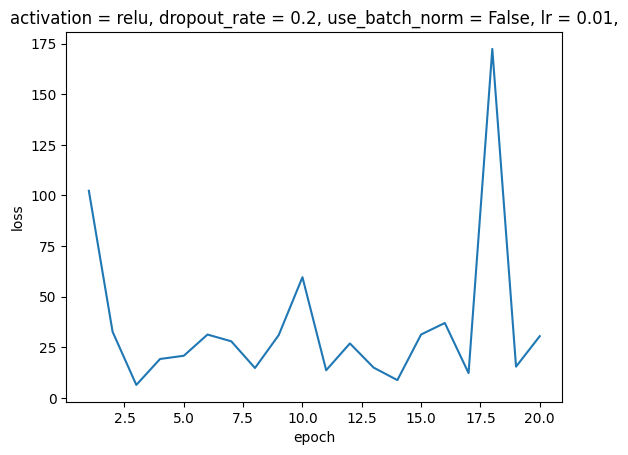

Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 15.5135
Epoch [2/20], Loss: 41.4931
Epoch [3/20], Loss: 31.1417
Epoch [4/20], Loss: 59.2600
Epoch [5/20], Loss: 46.3498
Epoch [6/20], Loss: 74.7028
Epoch [7/20], Loss: 28.8140
Epoch [8/20], Loss: 46.8846
Epoch [9/20], Loss: 26.2832
Epoch [10/20], Loss: 28.4552
Epoch [11/20], Loss: 70.2290
Epoch [12/20], Loss: 32.7829
Epoch [13/20], Loss: 45.4816
Epoch [14/20], Loss: 47.1905
Epoch [15/20], Loss: 14.3783
Epoch [16/20], Loss: 162.5951
Epoch [17/20], Loss: 12.3569
Epoch [18/20], Loss: 18.7372
Epoch [19/20], Loss: 38.8108
Epoch [20/20], Loss: 22.0300
Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.001,


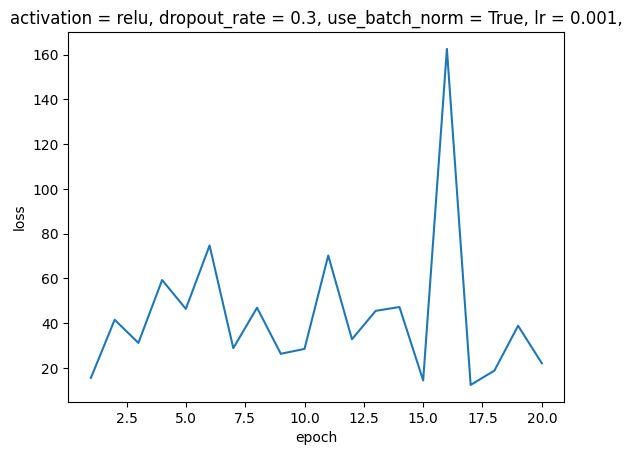

Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 119.8515
Epoch [2/20], Loss: 24.2951
Epoch [3/20], Loss: 39.5946
Epoch [4/20], Loss: 39.8374
Epoch [5/20], Loss: 7.1884
Epoch [6/20], Loss: 33.5679
Epoch [7/20], Loss: 17.7716
Epoch [8/20], Loss: 93.4909
Epoch [9/20], Loss: 9.9552
Epoch [10/20], Loss: 104.6737
Epoch [11/20], Loss: 22.2721
Epoch [12/20], Loss: 17.2918
Epoch [13/20], Loss: 11.8283
Epoch [14/20], Loss: 53.9761
Epoch [15/20], Loss: 15.5659
Epoch [16/20], Loss: 35.8785
Epoch [17/20], Loss: 20.8776
Epoch [18/20], Loss: 33.1674
Epoch [19/20], Loss: 10.0929
Epoch [20/20], Loss: 67.0571
Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.01,


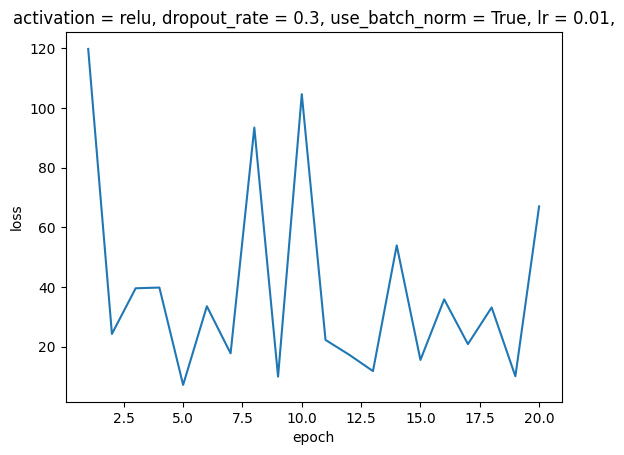

Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 27.6977
Epoch [2/20], Loss: 56.2759
Epoch [3/20], Loss: 20.1690
Epoch [4/20], Loss: 8.0212
Epoch [5/20], Loss: 34.4975
Epoch [6/20], Loss: 58.1187
Epoch [7/20], Loss: 35.8743
Epoch [8/20], Loss: 14.8871
Epoch [9/20], Loss: 22.9748
Epoch [10/20], Loss: 23.9670
Epoch [11/20], Loss: 14.3944
Epoch [12/20], Loss: 13.6797
Epoch [13/20], Loss: 49.0361
Epoch [14/20], Loss: 7.3055
Epoch [15/20], Loss: 12.3381
Epoch [16/20], Loss: 6.5794
Epoch [17/20], Loss: 32.4349
Epoch [18/20], Loss: 6.9856
Epoch [19/20], Loss: 27.5606
Epoch [20/20], Loss: 26.7670
Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.001,


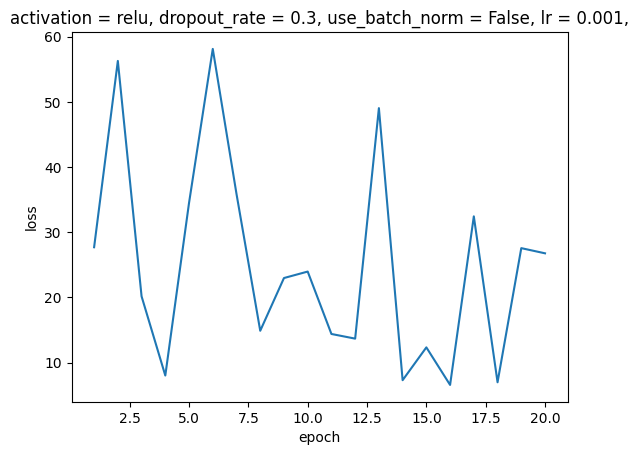

Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 103.9415
Epoch [2/20], Loss: 33.2706
Epoch [3/20], Loss: 24.7672
Epoch [4/20], Loss: 42.0529
Epoch [5/20], Loss: 27.1263
Epoch [6/20], Loss: 19.1555
Epoch [7/20], Loss: 62.8240
Epoch [8/20], Loss: 13.5838
Epoch [9/20], Loss: 13.4589
Epoch [10/20], Loss: 22.9737
Epoch [11/20], Loss: 18.9264
Epoch [12/20], Loss: 15.2683
Epoch [13/20], Loss: 8.3166
Epoch [14/20], Loss: 33.4780
Epoch [15/20], Loss: 34.0865
Epoch [16/20], Loss: 14.3990
Epoch [17/20], Loss: 13.9063
Epoch [18/20], Loss: 51.4002
Epoch [19/20], Loss: 53.0336
Epoch [20/20], Loss: 26.5344
Гиперпараметры модели: activation = relu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.01,


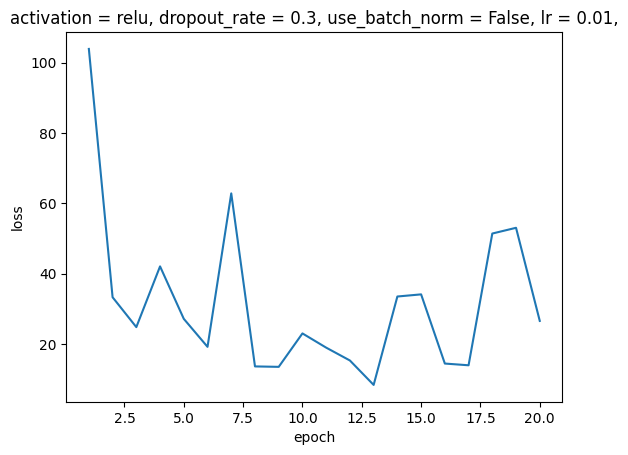

Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 11.8113
Epoch [2/20], Loss: 26.1275
Epoch [3/20], Loss: 17.6101
Epoch [4/20], Loss: 51.8896
Epoch [5/20], Loss: 46.8640
Epoch [6/20], Loss: 42.8077
Epoch [7/20], Loss: 11.0644
Epoch [8/20], Loss: 11.6771
Epoch [9/20], Loss: 11.0814
Epoch [10/20], Loss: 24.6700
Epoch [11/20], Loss: 57.9185
Epoch [12/20], Loss: 36.3906
Epoch [13/20], Loss: 21.4168
Epoch [14/20], Loss: 16.9511
Epoch [15/20], Loss: 60.8101
Epoch [16/20], Loss: 15.0655
Epoch [17/20], Loss: 17.2710
Epoch [18/20], Loss: 50.4687
Epoch [19/20], Loss: 21.8125
Epoch [20/20], Loss: 41.6576
Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.001,


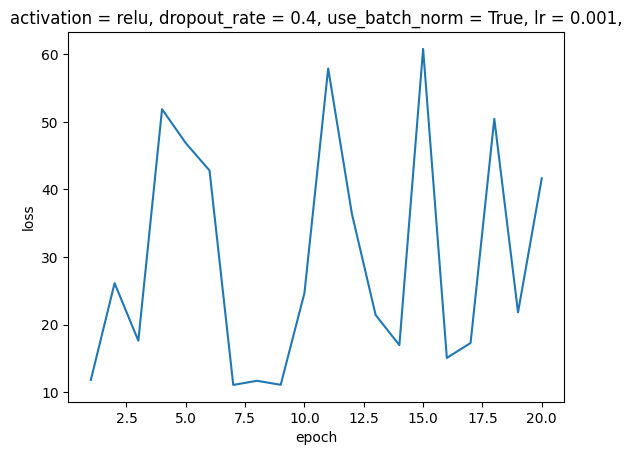

Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 40.7033
Epoch [2/20], Loss: 10.8543
Epoch [3/20], Loss: 23.8942
Epoch [4/20], Loss: 33.0567
Epoch [5/20], Loss: 136.5949
Epoch [6/20], Loss: 36.9307
Epoch [7/20], Loss: 219.0244
Epoch [8/20], Loss: 28.7444
Epoch [9/20], Loss: 18.2785
Epoch [10/20], Loss: 31.6520
Epoch [11/20], Loss: 26.1855
Epoch [12/20], Loss: 47.4687
Epoch [13/20], Loss: 40.7500
Epoch [14/20], Loss: 57.4290
Epoch [15/20], Loss: 24.7945
Epoch [16/20], Loss: 18.4017
Epoch [17/20], Loss: 8.3328
Epoch [18/20], Loss: 78.7232
Epoch [19/20], Loss: 73.4434
Epoch [20/20], Loss: 19.8870
Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.01,


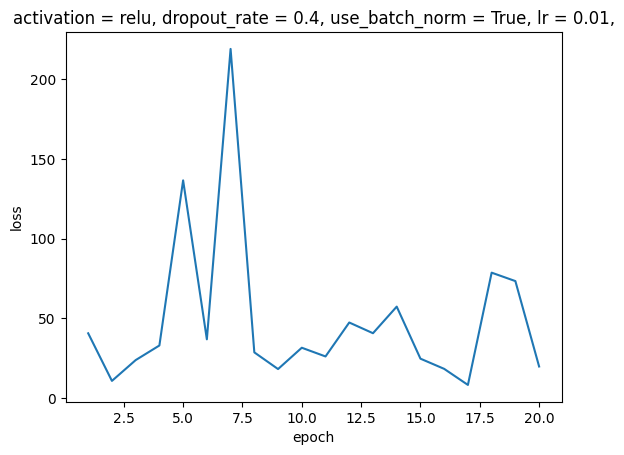

Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 44.5894
Epoch [2/20], Loss: 28.3846
Epoch [3/20], Loss: 16.0334
Epoch [4/20], Loss: 32.0775
Epoch [5/20], Loss: 9.3012
Epoch [6/20], Loss: 33.4894
Epoch [7/20], Loss: 43.2574
Epoch [8/20], Loss: 25.0782
Epoch [9/20], Loss: 15.2870
Epoch [10/20], Loss: 11.5197
Epoch [11/20], Loss: 10.5168
Epoch [12/20], Loss: 19.6987
Epoch [13/20], Loss: 6.0008
Epoch [14/20], Loss: 34.9626
Epoch [15/20], Loss: 26.7580
Epoch [16/20], Loss: 53.5150
Epoch [17/20], Loss: 64.5058
Epoch [18/20], Loss: 27.9088
Epoch [19/20], Loss: 5.5951
Epoch [20/20], Loss: 18.2640
Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.001,


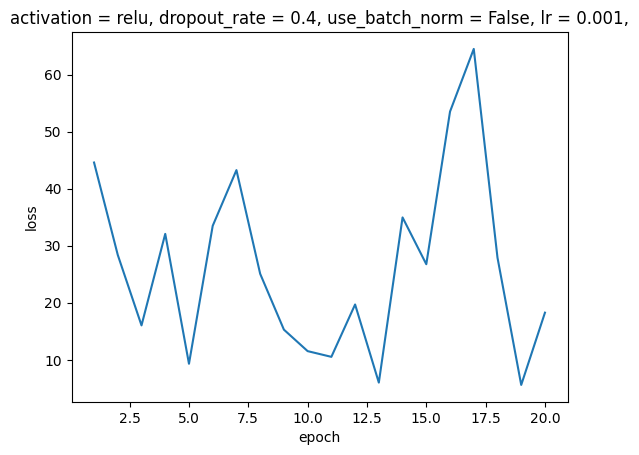

Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 33.0151
Epoch [2/20], Loss: 51.2562
Epoch [3/20], Loss: 52.9316
Epoch [4/20], Loss: 30.2337
Epoch [5/20], Loss: 19.2411
Epoch [6/20], Loss: 59.1900
Epoch [7/20], Loss: 31.4950
Epoch [8/20], Loss: 52.9635
Epoch [9/20], Loss: 58.5092
Epoch [10/20], Loss: 51.5129
Epoch [11/20], Loss: 17.8043
Epoch [12/20], Loss: 19.2413
Epoch [13/20], Loss: 11.7448
Epoch [14/20], Loss: 28.9012
Epoch [15/20], Loss: 34.9911
Epoch [16/20], Loss: 42.5889
Epoch [17/20], Loss: 69.0238
Epoch [18/20], Loss: 57.2344
Epoch [19/20], Loss: 20.4755
Epoch [20/20], Loss: 23.6361
Гиперпараметры модели: activation = relu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.01,


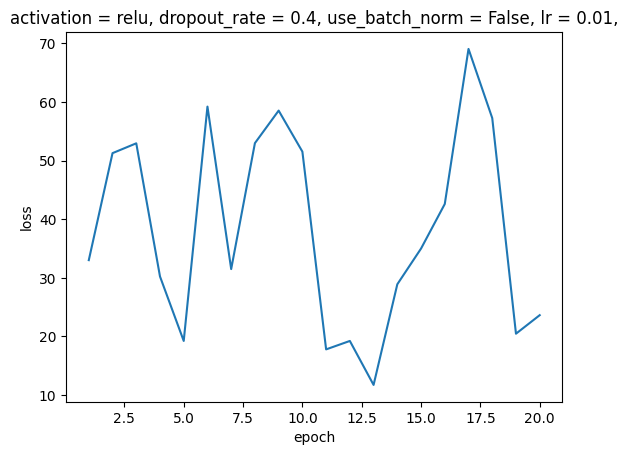

Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 105.6090
Epoch [2/20], Loss: 19.6255
Epoch [3/20], Loss: 37.5210
Epoch [4/20], Loss: 56.0824
Epoch [5/20], Loss: 30.3358
Epoch [6/20], Loss: 69.3614
Epoch [7/20], Loss: 12.3504
Epoch [8/20], Loss: 15.2293
Epoch [9/20], Loss: 23.6872
Epoch [10/20], Loss: 117.8224
Epoch [11/20], Loss: 11.7459
Epoch [12/20], Loss: 135.5641
Epoch [13/20], Loss: 16.2391
Epoch [14/20], Loss: 12.4447
Epoch [15/20], Loss: 23.9637
Epoch [16/20], Loss: 39.1122
Epoch [17/20], Loss: 31.2171
Epoch [18/20], Loss: 11.3834
Epoch [19/20], Loss: 47.8786
Epoch [20/20], Loss: 104.0498
Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.001,


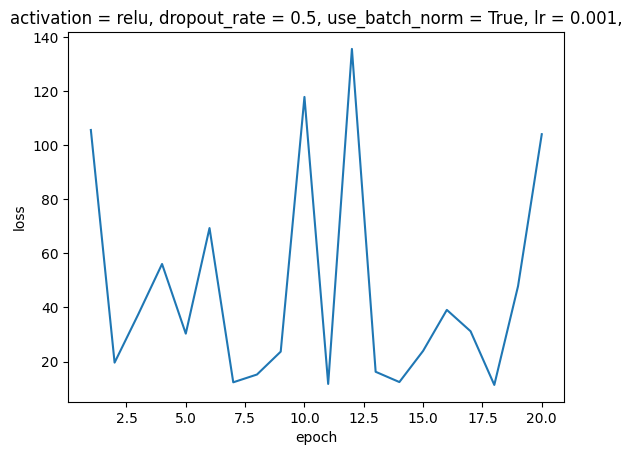

Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 20.4888
Epoch [2/20], Loss: 44.9468
Epoch [3/20], Loss: 40.2758
Epoch [4/20], Loss: 11.1413
Epoch [5/20], Loss: 20.7123
Epoch [6/20], Loss: 22.7539
Epoch [7/20], Loss: 4.8895
Epoch [8/20], Loss: 24.1493
Epoch [9/20], Loss: 27.6804
Epoch [10/20], Loss: 74.8525
Epoch [11/20], Loss: 74.6536
Epoch [12/20], Loss: 24.9480
Epoch [13/20], Loss: 30.6794
Epoch [14/20], Loss: 21.1989
Epoch [15/20], Loss: 42.8887
Epoch [16/20], Loss: 15.1194
Epoch [17/20], Loss: 28.4821
Epoch [18/20], Loss: 34.9326
Epoch [19/20], Loss: 13.0299
Epoch [20/20], Loss: 16.7449
Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.01,


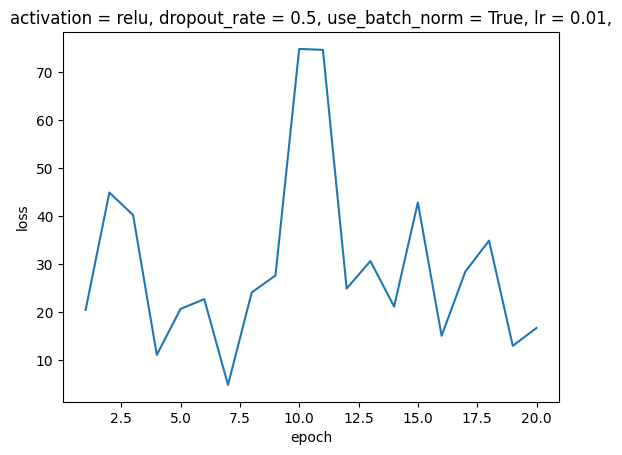

Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 25.8823
Epoch [2/20], Loss: 32.7110
Epoch [3/20], Loss: 26.5789
Epoch [4/20], Loss: 30.7661
Epoch [5/20], Loss: 24.8416
Epoch [6/20], Loss: 8.7397
Epoch [7/20], Loss: 10.6600
Epoch [8/20], Loss: 27.4226
Epoch [9/20], Loss: 16.0653
Epoch [10/20], Loss: 37.1594
Epoch [11/20], Loss: 20.0006
Epoch [12/20], Loss: 15.1696
Epoch [13/20], Loss: 18.9385
Epoch [14/20], Loss: 21.0300
Epoch [15/20], Loss: 19.5472
Epoch [16/20], Loss: 25.6944
Epoch [17/20], Loss: 16.7248
Epoch [18/20], Loss: 18.3614
Epoch [19/20], Loss: 17.5789
Epoch [20/20], Loss: 19.4166
Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.001,


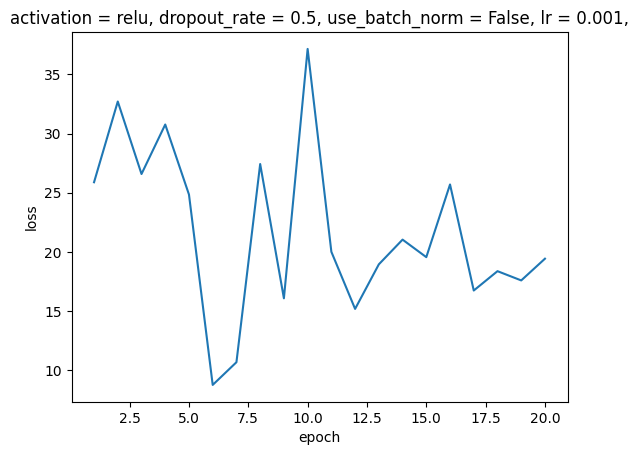

Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 37.3140
Epoch [2/20], Loss: 44.5543
Epoch [3/20], Loss: 43.1324
Epoch [4/20], Loss: 23.7037
Epoch [5/20], Loss: 42.6662
Epoch [6/20], Loss: 32.2917
Epoch [7/20], Loss: 14.4591
Epoch [8/20], Loss: 28.0732
Epoch [9/20], Loss: 20.0260
Epoch [10/20], Loss: 25.3436
Epoch [11/20], Loss: 18.8655
Epoch [12/20], Loss: 19.8039
Epoch [13/20], Loss: 44.6632
Epoch [14/20], Loss: 17.4748
Epoch [15/20], Loss: 56.4612
Epoch [16/20], Loss: 55.8055
Epoch [17/20], Loss: 52.4492
Epoch [18/20], Loss: 26.3310
Epoch [19/20], Loss: 93.6431
Epoch [20/20], Loss: 20.1793
Гиперпараметры модели: activation = relu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.01,


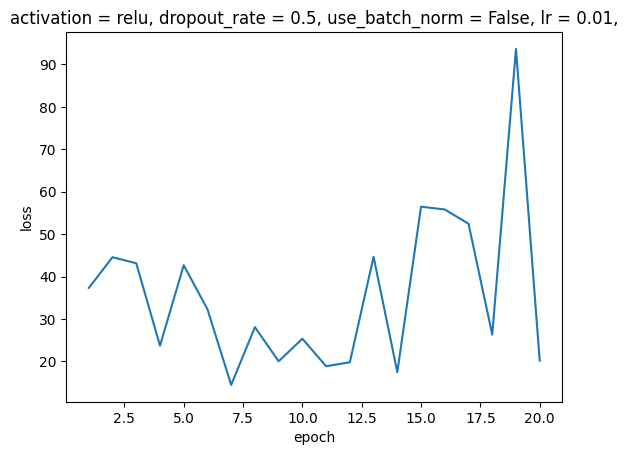

Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 54.9924
Epoch [2/20], Loss: 37.0653
Epoch [3/20], Loss: 10.3777
Epoch [4/20], Loss: 26.1222
Epoch [5/20], Loss: 10.7187
Epoch [6/20], Loss: 67.9395
Epoch [7/20], Loss: 16.5831
Epoch [8/20], Loss: 9.1661
Epoch [9/20], Loss: 86.5429
Epoch [10/20], Loss: 24.3696
Epoch [11/20], Loss: 17.6104
Epoch [12/20], Loss: 10.1643
Epoch [13/20], Loss: 17.6366
Epoch [14/20], Loss: 27.0268
Epoch [15/20], Loss: 19.1819
Epoch [16/20], Loss: 18.2882
Epoch [17/20], Loss: 25.2093
Epoch [18/20], Loss: 69.1319
Epoch [19/20], Loss: 33.3730
Epoch [20/20], Loss: 17.6501
Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.001,


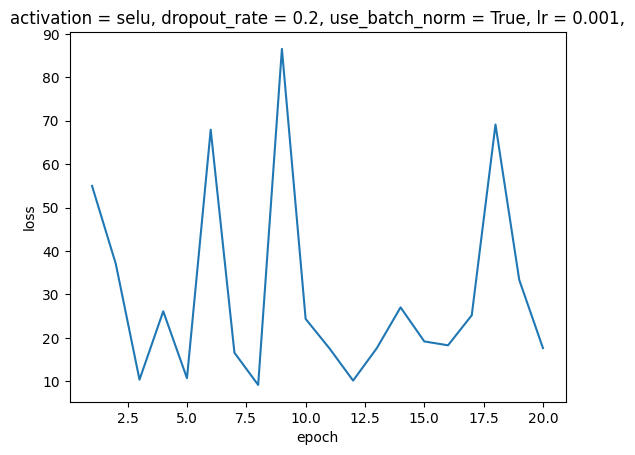

Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 32.2510
Epoch [2/20], Loss: 36.2855
Epoch [3/20], Loss: 22.1251
Epoch [4/20], Loss: 48.3579
Epoch [5/20], Loss: 29.8084
Epoch [6/20], Loss: 22.5228
Epoch [7/20], Loss: 26.0918
Epoch [8/20], Loss: 40.1461
Epoch [9/20], Loss: 19.3364
Epoch [10/20], Loss: 22.8299
Epoch [11/20], Loss: 67.8421
Epoch [12/20], Loss: 7.6379
Epoch [13/20], Loss: 21.9877
Epoch [14/20], Loss: 11.0017
Epoch [15/20], Loss: 33.9429
Epoch [16/20], Loss: 6.4014
Epoch [17/20], Loss: 20.2046
Epoch [18/20], Loss: 14.5869
Epoch [19/20], Loss: 31.6484
Epoch [20/20], Loss: 40.3188
Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = True, lr = 0.01,


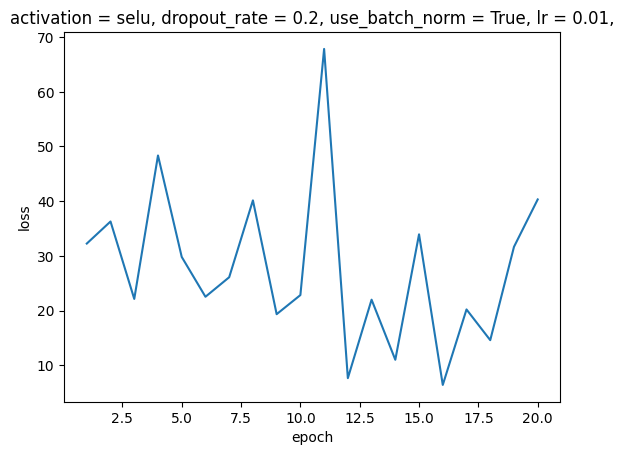

Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 21.6910
Epoch [2/20], Loss: 21.7382
Epoch [3/20], Loss: 30.7882
Epoch [4/20], Loss: 22.3148
Epoch [5/20], Loss: 47.6175
Epoch [6/20], Loss: 16.5468
Epoch [7/20], Loss: 18.7250
Epoch [8/20], Loss: 13.1748
Epoch [9/20], Loss: 33.7946
Epoch [10/20], Loss: 21.5220
Epoch [11/20], Loss: 19.8385
Epoch [12/20], Loss: 14.8090
Epoch [13/20], Loss: 22.4430
Epoch [14/20], Loss: 7.7337
Epoch [15/20], Loss: 3.3440
Epoch [16/20], Loss: 14.0101
Epoch [17/20], Loss: 16.5151
Epoch [18/20], Loss: 9.2269
Epoch [19/20], Loss: 29.4590
Epoch [20/20], Loss: 7.6034
Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.001,


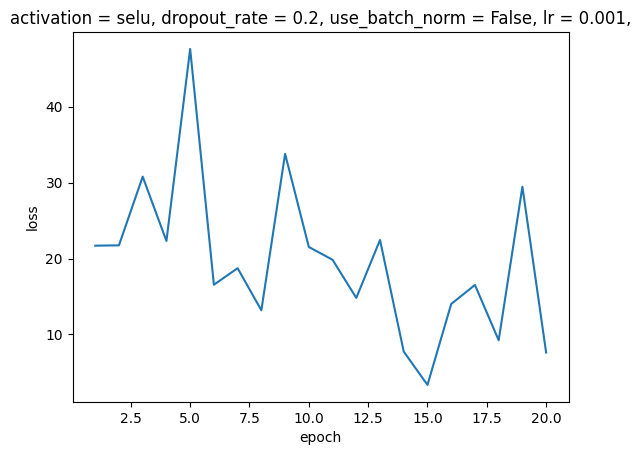

Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 39.7309
Epoch [2/20], Loss: 16.6933
Epoch [3/20], Loss: 9.5368
Epoch [4/20], Loss: 51.0452
Epoch [5/20], Loss: 39.2360
Epoch [6/20], Loss: 37.5960
Epoch [7/20], Loss: 52.1900
Epoch [8/20], Loss: 6.9946
Epoch [9/20], Loss: 15.4512
Epoch [10/20], Loss: 11.2895
Epoch [11/20], Loss: 13.9371
Epoch [12/20], Loss: 46.9257
Epoch [13/20], Loss: 38.9471
Epoch [14/20], Loss: 12.0979
Epoch [15/20], Loss: 29.3771
Epoch [16/20], Loss: 36.8905
Epoch [17/20], Loss: 48.5711
Epoch [18/20], Loss: 56.2116
Epoch [19/20], Loss: 56.2692
Epoch [20/20], Loss: 21.3176
Гиперпараметры модели: activation = selu, dropout_rate = 0.2, use_batch_norm = False, lr = 0.01,


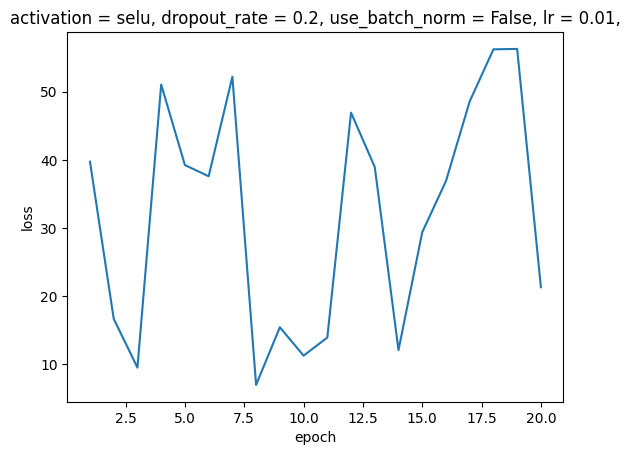

Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 17.2473
Epoch [2/20], Loss: 20.2684
Epoch [3/20], Loss: 18.3114
Epoch [4/20], Loss: 30.9620
Epoch [5/20], Loss: 26.6699
Epoch [6/20], Loss: 11.0323
Epoch [7/20], Loss: 8.2257
Epoch [8/20], Loss: 14.8456
Epoch [9/20], Loss: 39.1067
Epoch [10/20], Loss: 37.6062
Epoch [11/20], Loss: 67.0883
Epoch [12/20], Loss: 20.4503
Epoch [13/20], Loss: 39.0251
Epoch [14/20], Loss: 19.3974
Epoch [15/20], Loss: 31.2577
Epoch [16/20], Loss: 33.1488
Epoch [17/20], Loss: 82.8614
Epoch [18/20], Loss: 18.7375
Epoch [19/20], Loss: 11.1459
Epoch [20/20], Loss: 11.1112
Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.001,


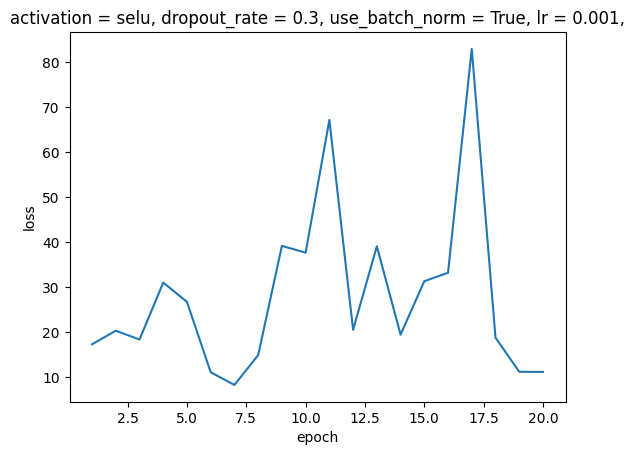

Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 18.8841
Epoch [2/20], Loss: 28.1127
Epoch [3/20], Loss: 23.7317
Epoch [4/20], Loss: 62.8138
Epoch [5/20], Loss: 25.9789
Epoch [6/20], Loss: 28.5673
Epoch [7/20], Loss: 31.6629
Epoch [8/20], Loss: 57.8208
Epoch [9/20], Loss: 30.6497
Epoch [10/20], Loss: 29.7925
Epoch [11/20], Loss: 35.5268
Epoch [12/20], Loss: 16.1483
Epoch [13/20], Loss: 20.7121
Epoch [14/20], Loss: 12.3619
Epoch [15/20], Loss: 18.6207
Epoch [16/20], Loss: 41.8724
Epoch [17/20], Loss: 65.9138
Epoch [18/20], Loss: 22.0271
Epoch [19/20], Loss: 15.3314
Epoch [20/20], Loss: 25.3276
Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = True, lr = 0.01,


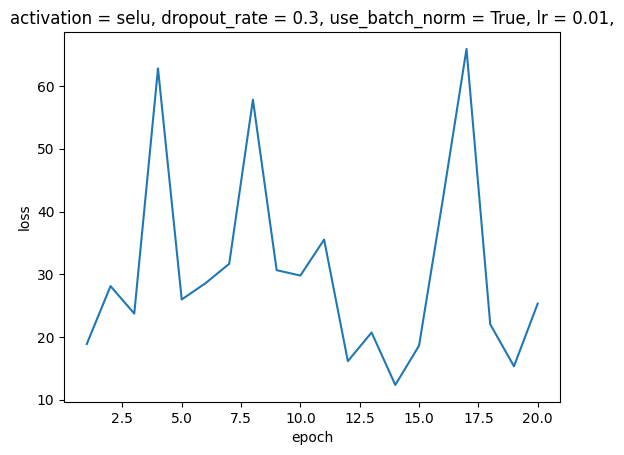

Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 18.0181
Epoch [2/20], Loss: 20.3150
Epoch [3/20], Loss: 37.7155
Epoch [4/20], Loss: 20.1698
Epoch [5/20], Loss: 13.3204
Epoch [6/20], Loss: 30.6917
Epoch [7/20], Loss: 6.7697
Epoch [8/20], Loss: 24.5274
Epoch [9/20], Loss: 20.1342
Epoch [10/20], Loss: 13.2174
Epoch [11/20], Loss: 24.9013
Epoch [12/20], Loss: 27.3353
Epoch [13/20], Loss: 24.3590
Epoch [14/20], Loss: 12.2435
Epoch [15/20], Loss: 14.2435
Epoch [16/20], Loss: 23.2581
Epoch [17/20], Loss: 11.4276
Epoch [18/20], Loss: 17.3899
Epoch [19/20], Loss: 43.1240
Epoch [20/20], Loss: 17.8865
Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.001,


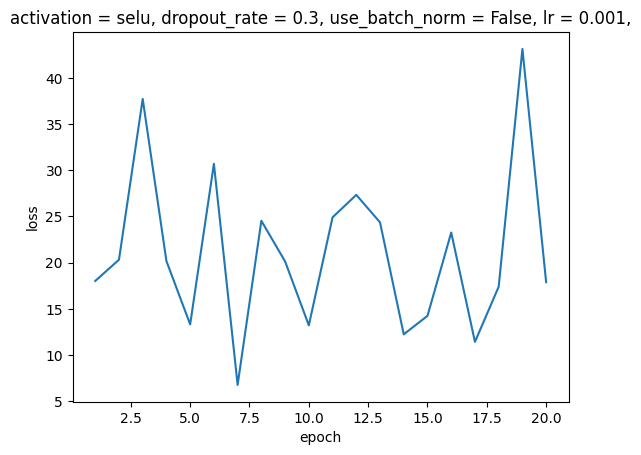

Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 87.4753
Epoch [2/20], Loss: 26.6359
Epoch [3/20], Loss: 21.9930
Epoch [4/20], Loss: 33.3255
Epoch [5/20], Loss: 38.8681
Epoch [6/20], Loss: 54.8456
Epoch [7/20], Loss: 36.8564
Epoch [8/20], Loss: 53.9740
Epoch [9/20], Loss: 18.8759
Epoch [10/20], Loss: 46.4598
Epoch [11/20], Loss: 20.0157
Epoch [12/20], Loss: 30.8773
Epoch [13/20], Loss: 24.1764
Epoch [14/20], Loss: 48.9166
Epoch [15/20], Loss: 18.8606
Epoch [16/20], Loss: 23.0085
Epoch [17/20], Loss: 28.6954
Epoch [18/20], Loss: 48.3639
Epoch [19/20], Loss: 15.4747
Epoch [20/20], Loss: 36.0496
Гиперпараметры модели: activation = selu, dropout_rate = 0.3, use_batch_norm = False, lr = 0.01,


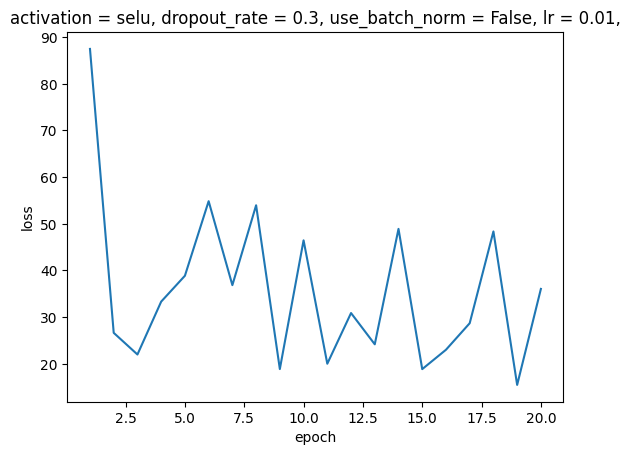

Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 57.6048
Epoch [2/20], Loss: 50.1307
Epoch [3/20], Loss: 67.0661
Epoch [4/20], Loss: 23.3434
Epoch [5/20], Loss: 34.3122
Epoch [6/20], Loss: 19.8256
Epoch [7/20], Loss: 57.0810
Epoch [8/20], Loss: 11.2002
Epoch [9/20], Loss: 28.3823
Epoch [10/20], Loss: 51.3624
Epoch [11/20], Loss: 10.6595
Epoch [12/20], Loss: 50.8698
Epoch [13/20], Loss: 27.5941
Epoch [14/20], Loss: 39.4647
Epoch [15/20], Loss: 24.8809
Epoch [16/20], Loss: 20.5322
Epoch [17/20], Loss: 5.7000
Epoch [18/20], Loss: 37.1199
Epoch [19/20], Loss: 28.1521
Epoch [20/20], Loss: 20.7350
Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.001,


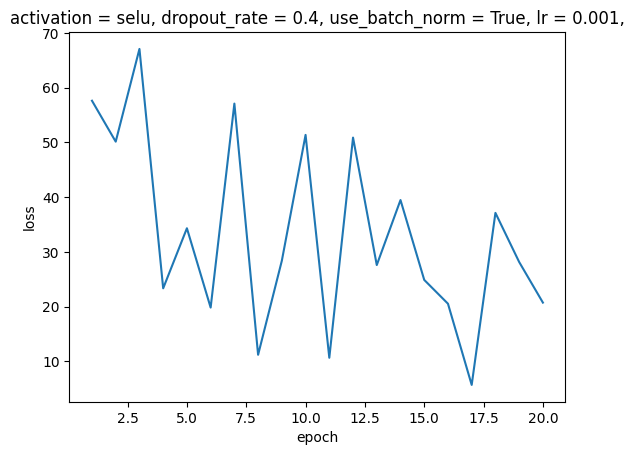

Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 25.0036
Epoch [2/20], Loss: 75.8016
Epoch [3/20], Loss: 38.3662
Epoch [4/20], Loss: 18.6959
Epoch [5/20], Loss: 5.6110
Epoch [6/20], Loss: 15.8859
Epoch [7/20], Loss: 12.4684
Epoch [8/20], Loss: 23.7892
Epoch [9/20], Loss: 43.5525
Epoch [10/20], Loss: 48.9377
Epoch [11/20], Loss: 39.4134
Epoch [12/20], Loss: 42.1224
Epoch [13/20], Loss: 17.4830
Epoch [14/20], Loss: 30.9337
Epoch [15/20], Loss: 11.2807
Epoch [16/20], Loss: 19.0765
Epoch [17/20], Loss: 18.6278
Epoch [18/20], Loss: 59.5419
Epoch [19/20], Loss: 53.9266
Epoch [20/20], Loss: 61.0093
Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = True, lr = 0.01,


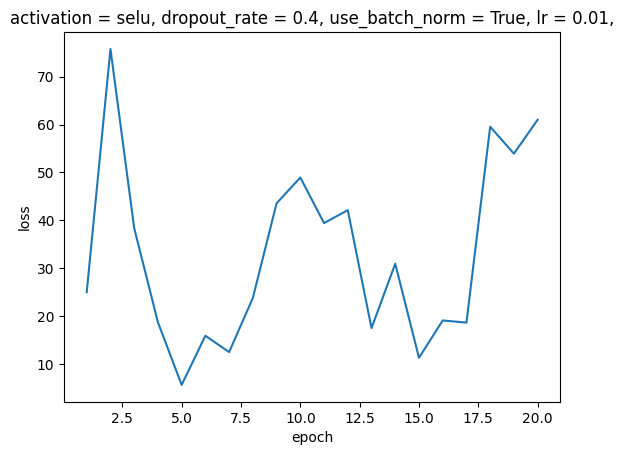

Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 30.7802
Epoch [2/20], Loss: 14.8870
Epoch [3/20], Loss: 18.3248
Epoch [4/20], Loss: 33.5323
Epoch [5/20], Loss: 26.9256
Epoch [6/20], Loss: 39.2875
Epoch [7/20], Loss: 13.2922
Epoch [8/20], Loss: 25.2166
Epoch [9/20], Loss: 33.6522
Epoch [10/20], Loss: 7.9769
Epoch [11/20], Loss: 11.9017
Epoch [12/20], Loss: 10.7605
Epoch [13/20], Loss: 6.0081
Epoch [14/20], Loss: 13.8354
Epoch [15/20], Loss: 44.7258
Epoch [16/20], Loss: 26.1648
Epoch [17/20], Loss: 12.8163
Epoch [18/20], Loss: 178.7779
Epoch [19/20], Loss: 31.8748
Epoch [20/20], Loss: 39.6503
Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.001,


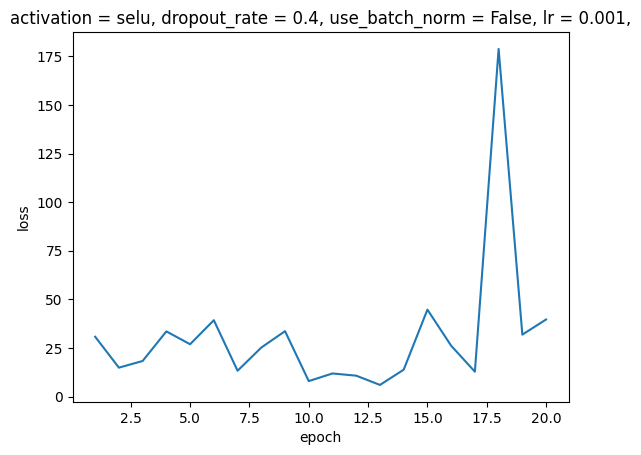

Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 60.5492
Epoch [2/20], Loss: 42.1379
Epoch [3/20], Loss: 19.1739
Epoch [4/20], Loss: 23.6996
Epoch [5/20], Loss: 36.8277
Epoch [6/20], Loss: 49.7057
Epoch [7/20], Loss: 109.3897
Epoch [8/20], Loss: 26.9915
Epoch [9/20], Loss: 17.1532
Epoch [10/20], Loss: 17.2974
Epoch [11/20], Loss: 22.4781
Epoch [12/20], Loss: 52.2570
Epoch [13/20], Loss: 12.5651
Epoch [14/20], Loss: 27.6657
Epoch [15/20], Loss: 49.7641
Epoch [16/20], Loss: 6.5521
Epoch [17/20], Loss: 23.7567
Epoch [18/20], Loss: 62.5281
Epoch [19/20], Loss: 35.2489
Epoch [20/20], Loss: 104.9137
Гиперпараметры модели: activation = selu, dropout_rate = 0.4, use_batch_norm = False, lr = 0.01,


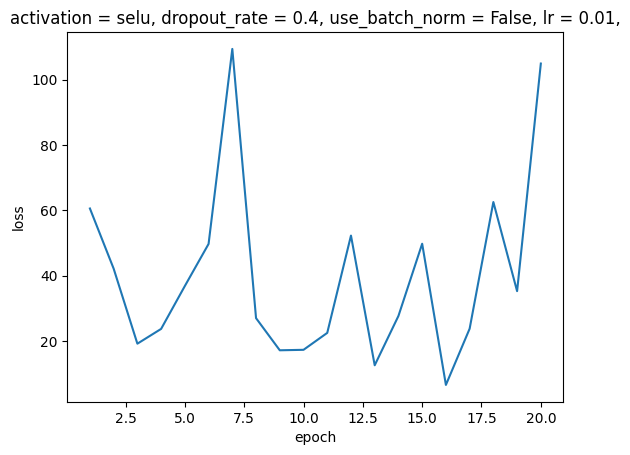

Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.001,
Epoch [1/20], Loss: 26.3622
Epoch [2/20], Loss: 28.6044
Epoch [3/20], Loss: 26.8588
Epoch [4/20], Loss: 33.9319
Epoch [5/20], Loss: 6.5298
Epoch [6/20], Loss: 17.1922
Epoch [7/20], Loss: 27.7671
Epoch [8/20], Loss: 31.5705
Epoch [9/20], Loss: 33.6584
Epoch [10/20], Loss: 38.9236
Epoch [11/20], Loss: 32.1050
Epoch [12/20], Loss: 42.7038
Epoch [13/20], Loss: 12.8121
Epoch [14/20], Loss: 44.0970
Epoch [15/20], Loss: 18.8919
Epoch [16/20], Loss: 118.7508
Epoch [17/20], Loss: 14.4103
Epoch [18/20], Loss: 23.5598
Epoch [19/20], Loss: 28.5486
Epoch [20/20], Loss: 28.9692
Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.001,


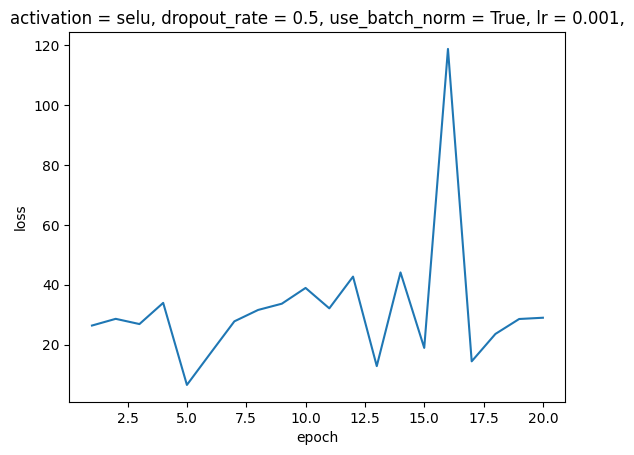

Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.01,
Epoch [1/20], Loss: 47.2565
Epoch [2/20], Loss: 23.3012
Epoch [3/20], Loss: 22.3558
Epoch [4/20], Loss: 20.9645
Epoch [5/20], Loss: 22.3512
Epoch [6/20], Loss: 48.6534
Epoch [7/20], Loss: 27.1794
Epoch [8/20], Loss: 29.2087
Epoch [9/20], Loss: 20.4839
Epoch [10/20], Loss: 17.9413
Epoch [11/20], Loss: 24.0955
Epoch [12/20], Loss: 9.9704
Epoch [13/20], Loss: 44.9463
Epoch [14/20], Loss: 41.8932
Epoch [15/20], Loss: 35.7147
Epoch [16/20], Loss: 24.5697
Epoch [17/20], Loss: 17.6995
Epoch [18/20], Loss: 16.3986
Epoch [19/20], Loss: 23.9474
Epoch [20/20], Loss: 51.2120
Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = True, lr = 0.01,


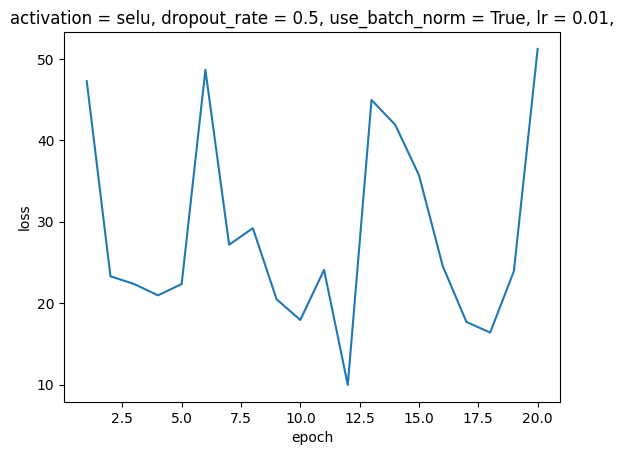

Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.001,
Epoch [1/20], Loss: 16.7534
Epoch [2/20], Loss: 61.8637
Epoch [3/20], Loss: 15.7294
Epoch [4/20], Loss: 19.0058
Epoch [5/20], Loss: 12.9021
Epoch [6/20], Loss: 14.4913
Epoch [7/20], Loss: 26.5413
Epoch [8/20], Loss: 10.5647
Epoch [9/20], Loss: 44.1344
Epoch [10/20], Loss: 27.9945
Epoch [11/20], Loss: 41.4678
Epoch [12/20], Loss: 12.2442
Epoch [13/20], Loss: 40.0196
Epoch [14/20], Loss: 15.6077
Epoch [15/20], Loss: 22.6429
Epoch [16/20], Loss: 17.1077
Epoch [17/20], Loss: 10.1156
Epoch [18/20], Loss: 11.4289
Epoch [19/20], Loss: 21.7561
Epoch [20/20], Loss: 16.4710
Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.001,


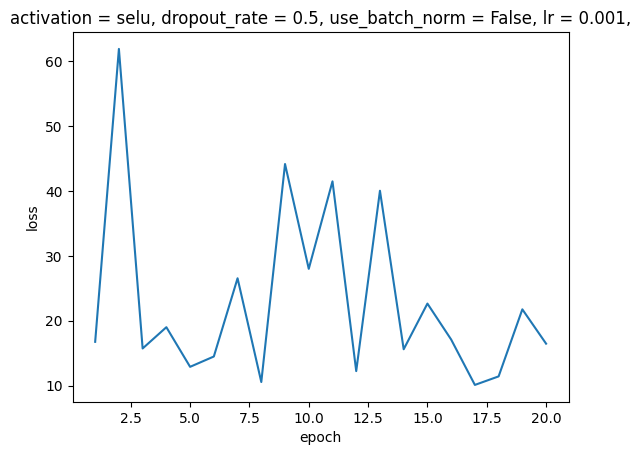

Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.01,
Epoch [1/20], Loss: 33.5175
Epoch [2/20], Loss: 47.0635
Epoch [3/20], Loss: 61.7439
Epoch [4/20], Loss: 27.8087
Epoch [5/20], Loss: 43.8234
Epoch [6/20], Loss: 25.4563
Epoch [7/20], Loss: 26.3520
Epoch [8/20], Loss: 51.5038
Epoch [9/20], Loss: 17.1785
Epoch [10/20], Loss: 29.8760
Epoch [11/20], Loss: 42.7921
Epoch [12/20], Loss: 53.0539
Epoch [13/20], Loss: 116.9261
Epoch [14/20], Loss: 66.0458
Epoch [15/20], Loss: 72.4714
Epoch [16/20], Loss: 102.5602
Epoch [17/20], Loss: 50.4864
Epoch [18/20], Loss: 71.9897
Epoch [19/20], Loss: 149.6441
Epoch [20/20], Loss: 74.1812
Гиперпараметры модели: activation = selu, dropout_rate = 0.5, use_batch_norm = False, lr = 0.01,


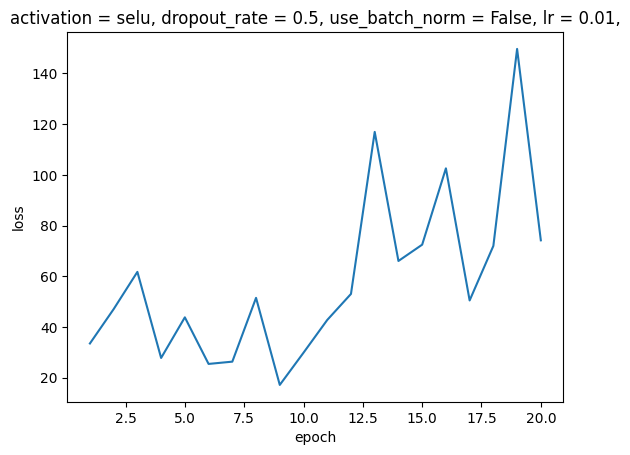

In [17]:
for activation in param_grid['activation']:
    for dropout_rate in param_grid['dropout_rate']:
        for use_batch_norm in param_grid['use_batch_norm']:
            for lr in param_grid['lr']: 
                print(f"Гиперпараметры модели: activation = {activation}, dropout_rate = {dropout_rate}, use_batch_norm = {use_batch_norm}, lr = {lr},")
                input_dim = X_train.shape[1]
                model = Net(input_dim, activation = activation, dropout_rate = dropout_rate, use_batch_norm = use_batch_norm)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                num_epochs = 20
                list_epoch = []
                list_loss = []
                for epoch in range(num_epochs):
                    model.train()
                    for batch_x, batch_y in train_loader:
                        optimizer.zero_grad()
                        outputs = model(batch_x)
                        loss = criterion(outputs, batch_y)
                        loss.backward()
                        optimizer.step()
                    
                    #вывод эпохи и Loss
                    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

                    #создание датафрейма для постороения кривой обучения
                    list_epoch.append(epoch+1)
                    list_loss.append(loss.item())
                data_learning = pd.DataFrame({'epoch' : list_epoch, 'loss' : list_loss})
                
                # Создание кривой обучения, вывод метрик

                sns.lineplot(x='epoch', y='loss', data = data_learning).set(title=f"activation = {activation}, dropout_rate = {dropout_rate}, use_batch_norm = {use_batch_norm}, lr = {lr},")
                print(f"Гиперпараметры модели: activation = {activation}, dropout_rate = {dropout_rate}, use_batch_norm = {use_batch_norm}, lr = {lr},")
                
                plt.show()
                plt.close()
                print('=====================================')




**Финальное обучение на лучших гиперпараметрах**

In [25]:
input_dim = X_train.shape[1]
model = Net(input_dim, activation = 'relu', dropout_rate = 0.2, use_batch_norm = True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
num_epochs = 13
list_epoch = []
list_loss = []
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    #вывод эпохи и Loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    #создание датафрейма для постороения кривой обучения
    list_epoch.append(epoch+1)
    list_loss.append(loss.item())
data_learning = pd.DataFrame({'epoch' : list_epoch, 'loss' : list_loss})

Epoch [1/13], Loss: 40.8331
Epoch [2/13], Loss: 53.0574
Epoch [3/13], Loss: 15.2277
Epoch [4/13], Loss: 39.3986
Epoch [5/13], Loss: 41.5184
Epoch [6/13], Loss: 17.9758
Epoch [7/13], Loss: 25.9608
Epoch [8/13], Loss: 28.1628
Epoch [9/13], Loss: 20.6182
Epoch [10/13], Loss: 36.1004
Epoch [11/13], Loss: 69.1132
Epoch [12/13], Loss: 25.5945
Epoch [13/13], Loss: 16.8845


<Axes: xlabel='epoch', ylabel='loss'>

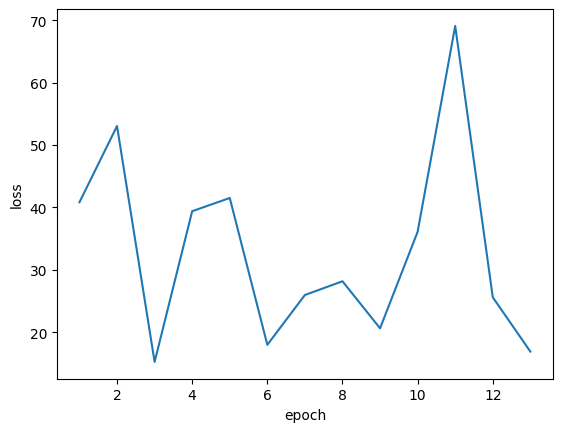

In [27]:
sns.lineplot(x='epoch', y='loss', data = data_learning)

In [32]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
y_pred = pd.DataFrame(test_outputs.cpu().detach().numpy()).rename(columns={0: 'score'})

Test Loss: 24.9391


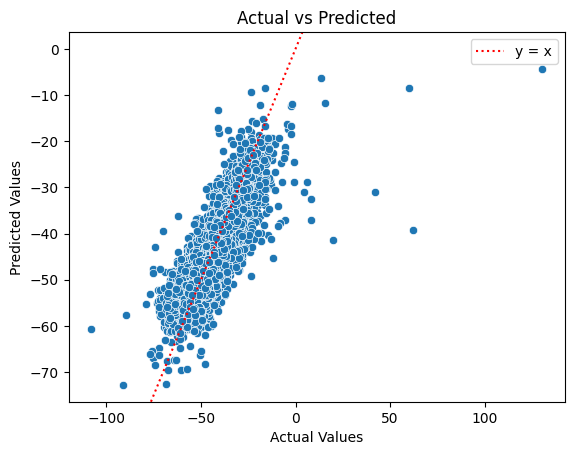

In [37]:
y_pred = test_outputs.cpu().numpy().flatten()  # Преобразуем к 1D массиву
y_test_np = y_test_tensor.cpu().numpy().flatten()  # Если y_test_tensor тоже 2D

sns.scatterplot(x=y_test_np, y=y_pred)
plt.axline((0, 0), slope=1, color='r', linestyle=':', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [42]:
r2 = r2_score(y_test_np, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
mae = mean_absolute_error(y_test_np, y_pred)

print(f'R² Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R² Score: 0.7029
RMSE: 4.9939
MAE: 3.6273


In [ ]:
y_array = y.values.ravel()
r2_scores = cross_val_score(model, X, y_array, scoring="r2")

rmse_scores = -cross_val_score(model, X, y_array, cv=cv,
                               scoring="neg_root_mean_squared_error")
# MAE
mae_scores = -cross_val_score(model, X, y_array, cv=cv,
                              scoring="neg_mean_absolute_error")

print("===== Результаты кросс-валидации =====")
print(f"Средний R² : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"Средний RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print(f"Средний MAE : {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")



metrics_df = pd.DataFrame({
    "R2":   r2_scores,
    "RMSE": rmse_scores,
    "MAE":  mae_scores
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_df, palette="pastel")
sns.swarmplot(data=metrics_df, color=".25", size=6)  # точки каждого фолда
plt.title("Кросс-валидация: распределение метрик по фолдам")
plt.ylabel("Значение метрики")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, cv.n_splits + 1), r2_scores, marker='o')
plt.title("R² на каждом фолде")
plt.xlabel("Фолд")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid()
plt.show()

TypeError: 'numpy.ndarray' object is not callable